# Pix2Pix (hed2paint)

This notebook is adapted from the TensorFlow [pix2pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix). It trains a cGAN on a [Chinese landscape painting dataset](https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset). Most code is taken from the tutorial except for "Download Dataset" and "Remove Grayscale Images".

**Dependencies:**
1. [Chinese landscape painting dataset](https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset)
2. `hed.zip` - HED edge maps 
3. `diff.txt` - `hed.zip` does not contain edge maps for all original images. This diff file shows which files are not present.

**Modifications to Google Drive:**
1. Creates a `training_checkpoints` directory to save intermediary model parameters

## Set Up

In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

import numpy as np
import glob
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
GDRIVE_PATH = 'gdrive/MyDrive/ColabNotebooks/CSC2515_Project/Part2/'
PATH = '/root/.keras/'
EDGEMAP_DIR = PATH + 'edgemaps/hed/'
ORIG_IM_SIZE = 512

## Download Dataset

In [4]:
mkdir {PATH}train

In [5]:
mkdir {PATH}test

In [6]:
mkdir {PATH}edgemaps

In [ ]:
URLs = [
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Harvard/Harvard-1.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Metropolitan/Metropolitan-1.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Metropolitan/Metropolitan-2.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Princeton/Princeton-1.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Princeton/Princeton-2.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-2.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-3.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-4.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-5.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-6.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-7.zip',
        'https://github.com/alicex2020/Chinese-Landscape-Painting-Dataset/raw/main/All-Paintings/Smithsonian/Smithsonian-1.zip',
]

# Get training data
for i in range(len(URLs) - 1):
  url = URLs[i]
  zip_name = url.split('/')[-1]
  tf.keras.utils.get_file(zip_name,
                          origin=url,
                          extract=True,
                          cache_subdir='train')

# Get test data (the last zip is used as test)
url = URLs[-1]
zip_name = url.split('/')[-1]
tf.keras.utils.get_file(zip_name,
                        origin=url,
                        extract=True,
                        cache_subdir='test')

HED_URLs = [
        'https://github.com/Luxi-Zhao/sketch-to-Chinese-landscape-painting-data/raw/master/datasets/hed/hed.z01',
        'https://github.com/Luxi-Zhao/sketch-to-Chinese-landscape-painting-data/raw/master/datasets/hed/hed.z02',
        'https://github.com/Luxi-Zhao/sketch-to-Chinese-landscape-painting-data/raw/master/datasets/hed/hed.zip',
] 

# Get edge maps
for i in range(len(HED_URLs)):
  url = HED_URLs[i]
  zip_name = url.split('/')[-1]
  tf.keras.utils.get_file(zip_name,
                          origin=url,
                          extract=False,
                          cache_subdir='edgemaps')

# Get diff.txt
tf.keras.utils.get_file('diff.txt',
                          origin='https://github.com/Luxi-Zhao/sketch-to-Chinese-landscape-painting-data/raw/master/datasets/hed/diff.txt',
                          extract=False,
                          cache_subdir='/content')


Combine splitted zip files.

In [ ]:
!zip -q -s 0 {PATH}edgemaps/hed.zip --out {PATH}edgemaps/hed_single.zip

In [ ]:
!unzip -q {PATH}edgemaps/hed_single.zip -d {PATH}/edgemaps/

## Remove Grayscale and Unpaired Images

In [45]:
def get_im_from_path(im_path):
  im = Image.open(im_path)
  im_array = np.asarray(im, dtype=np.float32)
  return im_array

# These paintings do not have corresponding HED
# edge maps
def get_unpaired_imgs():
  unpaired = set()
  filepath = 'diff.txt' 
  with open(filepath, 'r') as file:
    for row in file:
      # remove newline character
      unpaired.add(row[:-1])

  return unpaired

def remove_imgs():
  unpaired = get_unpaired_imgs()

  # get all images from test and train directories
  files = glob.iglob(PATH + 't*/*/*.jpg', recursive=True)
  for f in files:
    img_name = f.split('/')[-1]

    # remove imgs not paired with hed
    if(img_name in unpaired):
      os.remove(f)
    # remove grayscale imgs
    else:
      im = get_im_from_path(f)
      if(im.shape != (ORIG_IM_SIZE, ORIG_IM_SIZE, 3)):
        os.remove(f)


In [46]:
remove_imgs()

## Load Dataset to Local Runtime


In [28]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [29]:
def get_edgemap_name_from_im_path_tf(image_file, edgemap_dir):
  edgemap_dir = tf.constant(edgemap_dir)
  prefix = tf.constant('out_')
  suffix = tf.constant('.jpg')

  filename = tf.strings.split(image_file, '/')[-1]
  filename = tf.strings.split(filename, '.')[0]
  filename = tf.strings.join([edgemap_dir, prefix, filename, suffix])
  return filename

In [30]:
def load(image_file):
  im = tf.io.read_file(image_file)
  im = tf.image.decode_jpeg(im)
  im = tf.cast(im, tf.float32)

  edge_path = get_edgemap_name_from_im_path_tf(image_file, EDGEMAP_DIR)
  edge = tf.io.read_file(edge_path)
  edge = tf.image.decode_jpeg(edge)
  edge = tf.cast(edge, tf.float32)
  edge = tf.image.grayscale_to_rgb(edge)
  return edge, im

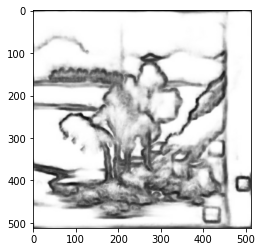

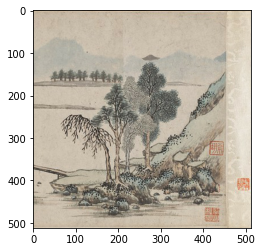

In [31]:
inp, re = load(PATH+'train/Harvard/harvard_0.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [32]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT + 60, IMG_WIDTH + 60)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)
  
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

In [47]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*/*.jpg')
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(PATH+'test/*/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator


In [34]:
OUTPUT_CHANNELS = 3
LAMBDA = 100

In [35]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[512,512,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 256, 256, 64)
    downsample(128, 4), # (bs, 128, 128, 128)
    downsample(256, 4), # (bs, 64, 64, 256)
    downsample(512, 4), # (bs, 32, 32, 512)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(512, 4), # (bs, 32, 32, 1024)
    upsample(256, 4), # (bs, 64, 64, 512)
    upsample(128, 4), # (bs, 128, 128, 256)
    upsample(64, 4), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 512, 512, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [36]:
generator = Generator()

## Build the Discriminator

In [37]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 512, 512, channels*2)

  down0 = downsample(64, 4, False)(x) # (bs, 256, 256, 64)
  down1 = downsample(128, 4)(down0) # (bs, 128, 128, 128)
  down2 = downsample(256, 4)(down1) # (bs, 64, 64, 256)
  down3 = downsample(512, 4)(down2) # (bs, 32, 32, 512)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 512)
  conv = tf.keras.layers.Conv2D(1024, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 1024)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 1024)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [38]:
discriminator = Discriminator()

## Define the Optimizers and Checkpoint-saver


In [39]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [40]:
checkpoint_dir = GDRIVE_PATH + 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Display Generated Images

In [41]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

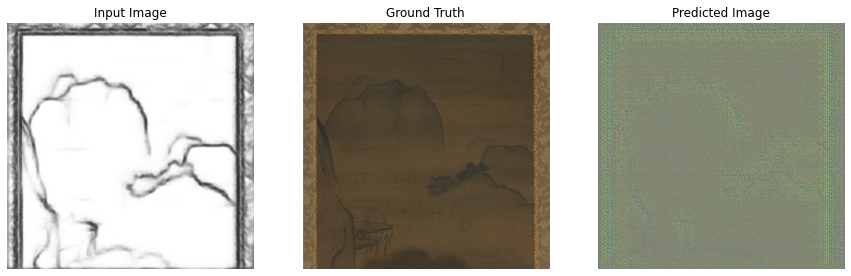

In [48]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

In [31]:
EPOCHS = 50

In [32]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

## Generate using Test Dataset

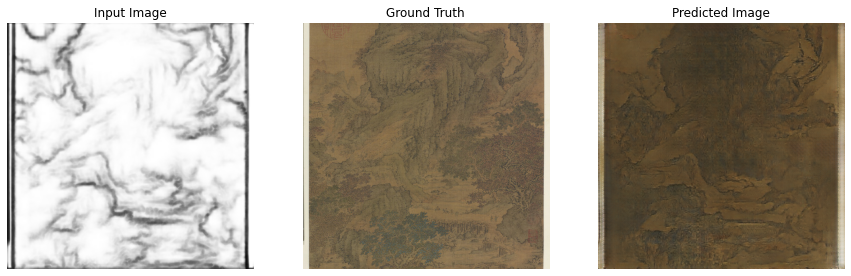

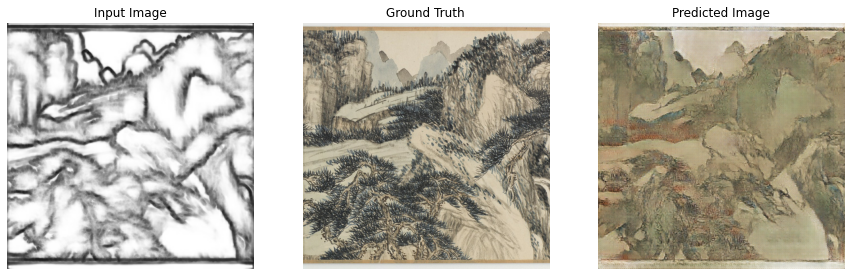

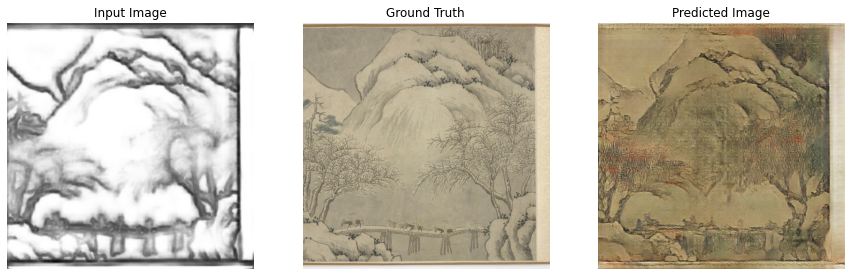

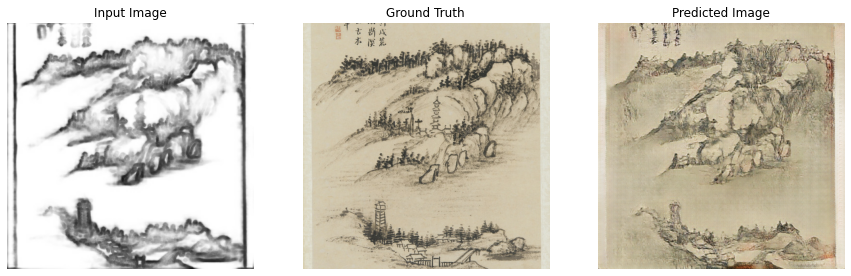

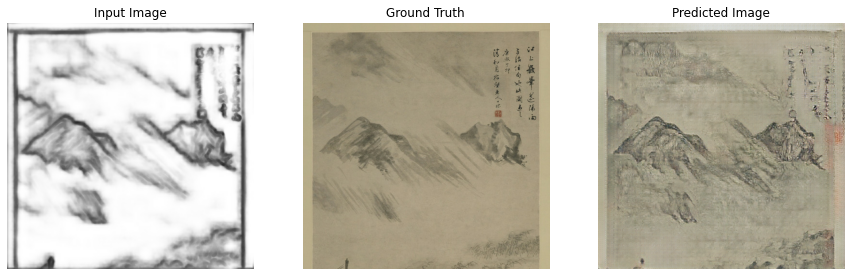

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)